In [ ]:
import os
import numpy as np
import pandas as pd
#visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-dark')
#image processing libraries
import glob as gb
from PIL import Image
from tensorflow.keras.preprocessing.image import  ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.preprocessing import image
#Models builidng essentials libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential,Model, load_model
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
#spliting the dataset into train, validation and training library
from sklearn.model_selection import train_test_split
#to check the time for execution
import time

In [ ]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/fish_health.zip"

Archive:  /content/drive/MyDrive/fish_health.zip
   creating: fish_health/healthy/
  inflating: fish_health/healthy/20180605_145616.jpg  
  inflating: fish_health/healthy/20180605_145627.jpg  
  inflating: fish_health/healthy/20180606_130901.jpg  
  inflating: fish_health/healthy/20180606_131343.jpg  
  inflating: fish_health/healthy/20180606_131350.jpg  
  inflating: fish_health/healthy/2416900.jpg  
  inflating: fish_health/healthy/5bd403bd7db5b70251676b06e42fabce.jfif  
  inflating: fish_health/healthy/a_red_tilapia_stock (10).jpg  
  inflating: fish_health/healthy/a_red_tilapia_stock (11).jpg  
  inflating: fish_health/healthy/a_red_tilapia_stock (12).jpg  
  inflating: fish_health/healthy/a_red_tilapia_stock (16).jpg  
  inflating: fish_health/healthy/a_red_tilapia_stock (19).jpg  
  inflating: fish_health/healthy/a_red_tilapia_stock (24).jpg  
  inflating: fish_health/healthy/a_red_tilapia_stock (26).jpg  
  inflating: fish_health/healthy/a_red_tilapia_stock (27).jpg  
  inflatin

In [ ]:
data_dir = 'fish_health'
# classes = ['char', 'perch', 'tilapia', 'trout']
classes = os.listdir(data_dir)
img_height, img_width = 224, 224
batch_size = 16
num_epochs = 100

In [ ]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for class_idx, class_name in enumerate(classes):
        class_folder = os.path.join(folder, class_name)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            img = Image.open(img_path).convert('RGB')
            img = img.resize((img_height, img_width))
            img = np.array(img) / 255.0
            images.append(img)
            labels.append(class_idx)

    return np.array(images), np.array(labels)

# Load and preprocess the images
images, labels = load_images_from_folder(data_dir)

# Convert labels to one-hot encoded vectors
num_classes = len(classes)
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
  def plot_history(history):
    fig, axs = plt.subplots(2)

    #create accuracy subplot
    axs[0].plot(history.history["accuracy"], label = 'train accuracy')
    axs[0].plot(history.history["val_accuracy"], label= 'test accuracy')
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc='lower right')
    axs[0].set_title("Accuracy eval")


    #create loss subplot
    axs[1].plot(history.history["loss"], label = 'train error')
    axs[1].plot(history.history["val_loss"], label = 'test error')
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc='upper right')
    axs[1].set_title("Error eval")

    plt.show()

In [ ]:
all_path=[] # To include the full path of each image
for img_path in os.listdir(data_dir):
    if img_path in ['Segmentation_example_script.m','README.txt','license.txt'] :
        continue
    # print(img_path)

    all_data=gb.glob(pathname=data_dir+'/'+img_path+'/*.*')
    print(' found {} in {} '.format(len(all_data),img_path))
    all_path.extend(all_data)

 found 1098 in unhealthy 
 found 1054 in healthy 


In [ ]:
images_df = pd.DataFrame({'FilePath': all_path})
images_df['Label'] = images_df['FilePath'].apply(lambda x: x.split('/')[-2])
pd.options.display.max_colwidth = 200


images_df = images_df.sample(frac=1).reset_index(drop=True)
images_df.head(5)


FilePath      Label
0                       fish_health/unhealthy/G_32_FlCbright.jpg  unhealthy
1                             fish_health/healthy/bream (12).jpg    healthy
2                              fish_health/healthy/bream (6).jpg    healthy
3        fish_health/healthy/LF_Salmon Trout-004-2.360_57567.jpg    healthy
4  fish_health/healthy/RF_Trout_014-705-37.5-1.34_00266Vflip.jpg    healthy

In [ ]:
print(images_df.shape)

(2152, 2)


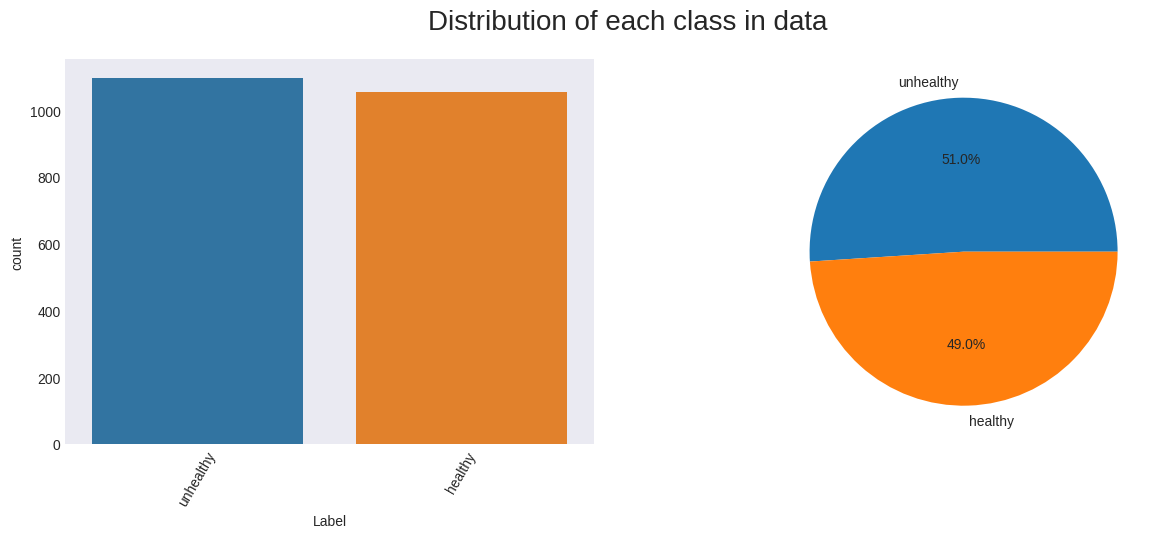

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=images_df,x='Label')
plt.xticks(rotation = 60)
plt.subplot(1,2,2)
plt.pie(x=images_df['Label'].value_counts().values,labels=images_df['Label'].value_counts().index,autopct='%1.1f%%')
plt.suptitle('Distribution of each class in data',size=20)
plt.show()

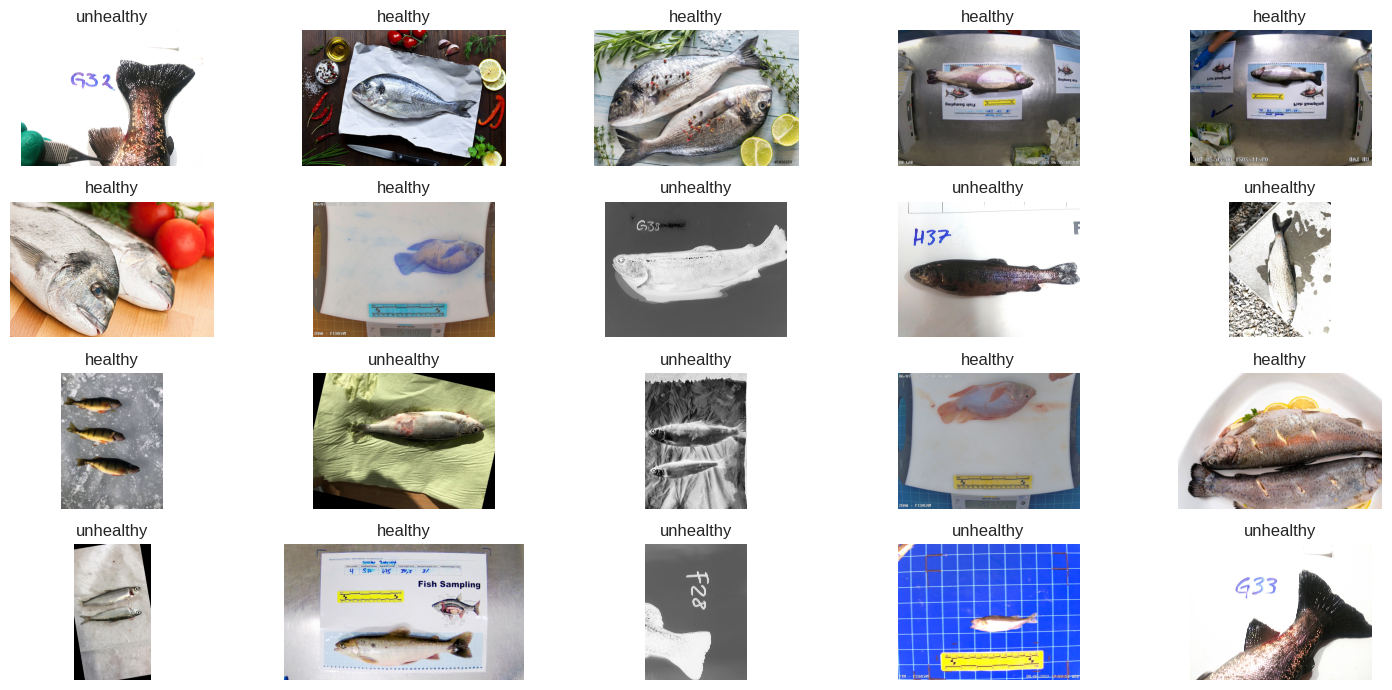

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15,7), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(images_df.FilePath[i]))
  ax.set_title(images_df.Label[i])

plt.tight_layout()
plt.show()

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
training_df,testing_df=train_test_split(images_df,test_size=0.1,shuffle=True,random_state=1)

print('The dimension of training data :',training_df.shape)
print('The dimension of testing data :',testing_df.shape)

The dimension of training data : (1936, 2)
The dimension of testing data : (216, 2)


In [ ]:
training_generator=ImageDataGenerator(
                                     tf.keras.applications.vgg16.preprocess_input,
                                       validation_split = 0.1

                                      )

testing_generator=ImageDataGenerator(
                                    tf.keras.applications.vgg16.preprocess_input
                                    )

In [ ]:
training_images=training_generator.flow_from_dataframe(

    dataframe=training_df,
    x_col='FilePath',
    y_col='Label',
    class_mode='categorical',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training',



)
validation_images=training_generator.flow_from_dataframe(


    dataframe=training_df,
    x_col='FilePath',
    y_col='Label',
    class_mode='categorical',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'

)
testing_images=testing_generator.flow_from_dataframe(


    dataframe=testing_df,
    x_col='FilePath',
    y_col='Label',
    class_mode='categorical',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    shuffle=False,
)


Found 1740 validated image filenames belonging to 2 classes.
Found 193 validated image filenames belonging to 2 classes.
Found 216 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="FilePath". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="FilePath". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
pre_trained_model = InceptionV3(input_shape = (img_width, img_height, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.959):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True
# early_stopping =EarlyStopping(monitor='val_loss', patience=18, verbose=1, restore_best_weights=True)

# reduce_lr=ReduceLROnPlateau(monitor='val_loss',patience=4,verbose=0,factor=0.1)

model_check_point=ModelCheckpoint(monitor='val_accuracy',filepath='/content/drive/MyDrive/inception_healthy_unhealthy/bestmodel.h5',save_best_only=True,verbose=True)

In [ ]:
# last_layer = pre_trained_model.get_layer('mixed7')
# print('last layer output shape: ', last_layer.output_shape)
# last_output = last_layer.output
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (len(classes), activation='sigmoid')(x)

model = Model( pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

In [ ]:
callbacks = myCallback()
history = model.fit_generator(
            training_images,
            validation_data = validation_images,
            epochs = 100,
            validation_steps = 20,
            verbose = 2,
            callbacks=[callbacks, model_check_point])

<ipython-input-21-f40fd8bcac9b>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


55/55 - 80s - loss: 52.9124 - acc: 0.5822 - val_loss: 12.4225 - val_acc: 0.5544 - 80s/epoch - 1s/step
Epoch 2/100


55/55 - 53s - loss: 7.1857 - acc: 0.6707 - 53s/epoch - 960ms/step
Epoch 3/100


55/55 - 51s - loss: 2.1909 - acc: 0.7029 - 51s/epoch - 933ms/step
Epoch 4/100


55/55 - 53s - loss: 1.4398 - acc: 0.7276 - 53s/epoch - 961ms/step
Epoch 5/100


55/55 - 55s - loss: 0.8078 - acc: 0.7816 - 55s/epoch - 1s/step
Epoch 6/100


55/55 - 53s - loss: 0.6850 - acc: 0.8213 - 53s/epoch - 958ms/step
Epoch 7/100


55/55 - 56s - loss: 0.9589 - acc: 0.8063 - 56s/epoch - 1s/step
Epoch 8/100


55/55 - 54s - loss: 0.6098 - acc: 0.8500 - 54s/epoch - 983ms/step
Epoch 9/100


55/55 - 54s - loss: 0.5389 - acc: 0.8644 - 54s/epoch - 980ms/step
Epoch 10/100


55/55 - 51s - loss: 0.3342 - acc: 0.8833 - 51s/epoch - 931ms/step
Epoch 11/100


55/55 - 56s - loss: 0.4224 - acc: 0.8839 - 56s/epoch - 1s/step
Epoch 12/100


55/55 - 51s - loss: 0.4527 - acc: 0.8891 - 51s/epoch - 936ms/step
Epoch 13/100


55/55 - 53s - loss: 0.3757 - acc: 0.9080 - 53s/epoch - 968ms/step
Epoch 14/100


55/55 - 57s - loss: 0.5268 - acc: 0.9080 - 57s/epoch - 1s/step
Epoch 15/100


55/55 - 57s - loss: 0.2265 - acc: 0.9276 - 57s/epoch - 1s/step
Epoch 16/100


55/55 - 53s - loss: 0.1955 - acc: 0.9368 - 53s/epoch - 958ms/step
Epoch 17/100


55/55 - 53s - loss: 0.1941 - acc: 0.9397 - 53s/epoch - 956ms/step
Epoch 18/100


55/55 - 52s - loss: 0.2400 - acc: 0.9339 - 52s/epoch - 948ms/step
Epoch 19/100


55/55 - 52s - loss: 0.2054 - acc: 0.9506 - 52s/epoch - 948ms/step
Epoch 20/100


55/55 - 52s - loss: 0.1931 - acc: 0.9454 - 52s/epoch - 946ms/step
Epoch 21/100


55/55 - 54s - loss: 0.2322 - acc: 0.9494 - 54s/epoch - 980ms/step
Epoch 22/100


55/55 - 53s - loss: 0.2414 - acc: 0.9471 - 53s/epoch - 960ms/step
Epoch 23/100


55/55 - 54s - loss: 0.1575 - acc: 0.9575 - 54s/epoch - 976ms/step
Epoch 24/100



Reached 99.9% accuracy so cancelling training!
55/55 - 53s - loss: 0.1337 - acc: 0.9592 - 53s/epoch - 966ms/step


In [ ]:
  model.save('/content/drive/MyDrive/inception_healthy_unhealthy/bestmodel.h5')

In [ ]:
incetionv3_model = load_model('/content/drive/MyDrive/inception_healthy_unhealthy/bestmodel.h5')


In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']
    tauc=tr_data.history['auc']
    vauc=tr_data.history['val_auc']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    auc_index=np.argmax(vauc)
    val_highest_auc=vauc[auc_index]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    auc_label='best epoch= ' + str(auc_index + 1 + start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=4, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()
    axes[3].plot(Epochs,tauc, 'r', label='Training AUC')
    axes[3].plot(Epochs,vauc,'g',label='Validation AUC' )
    axes[3].scatter(auc_index+1 +start_epoch,val_highest_auc, s=150, c= 'blue', label=sc_label)
    axes[3].scatter(Epochs, tauc, s=100, c='red')
    axes[3].set_title('Training and Validation AUC')
    axes[3].set_xlabel('Epochs', fontsize=18)
    axes[3].set_ylabel('AUC', fontsize=18)
    axes[3].legend()
    plt.tight_layout
    plt.show()
    return

tr_plot(history)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = testing_images.classes
y_pred = incetionv3_model.predict(testing_images).argmax(axis=-1)

cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=testing_images.class_indices.keys())

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


7/7 [==============================] - 11s 1s/step
Confusion Matrix:
[[ 95  13]
 [  5 103]]

Classification Report:
              precision    recall  f1-score   support

     healthy       0.95      0.88      0.91       108
   unhealthy       0.89      0.95      0.92       108

    accuracy                           0.92       216
   macro avg       0.92      0.92      0.92       216
weighted avg       0.92      0.92      0.92       216



In [ ]:
from sklearn import metrics

7/7 [==============================] - 6s 920ms/step


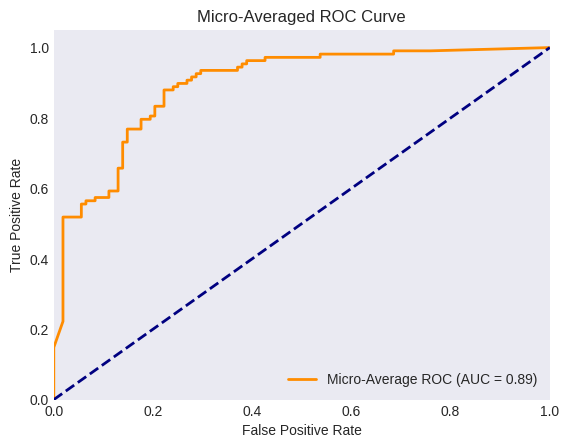

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

# Assuming you have already loaded your InceptionV3 model and have testing_images generator

# Get raw predictions from the model
y_pred_raw = incetionv3_model.predict(testing_images)

# Apply sigmoid to get probabilities for each class
y_pred_proba = 1 / (1 + np.exp(-y_pred_raw))

# Get true labels from the generator
y_true = testing_images.classes

# Get the number of classes (assuming binary classification)
num_classes = 2

# Compute micro-averaged ROC curve
fpr_micro, tpr_micro, _ = metrics.roc_curve(y_true, y_pred_proba[:, 1])  # Assuming positive class is 1
auc_micro = metrics.auc(fpr_micro, tpr_micro)

# Plot micro-averaged ROC curve
plt.figure()
plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=2, label=f'Micro-Average ROC (AUC = {auc_micro:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Averaged ROC Curve')
plt.legend(loc="lower right")
plt.show()
